# Using LX-Tokenizer to tokenize a text from the BDCamões corpus
This is an example notebook that illustrates how you can use the LX-Tokenizer web service to tokenize
a sample text from the BDCamões corpus (the full corpus is [available from the PORTULAN CLARIN repository](https://portulanclarin.net/repository/browse/bdcamoes-corpus-collection-of-portuguese-literary-documents-from-the-digital-library-of-camoes-ip-part-i/52f2b16412c411ea8a1302420a000005407eb504ccc045a4a0582ab53dfd43fd/)).

**Before you run this example**, replace `access_key_goes_here` by your webservice access key, below:

In [1]:
LXTOKENIZER_WS_API_KEY = 'access_key_goes_here'
LXTOKENIZER_WS_API_URL = 'https://portulanclarin.net/workbench/lx-tokenizer/api/'

## Importing required Python modules
The next cell will take care of installing the `requests` package,
if not already installed, and make IT available to use in this notebook.

In [2]:
try:
    import requests
except:
    !pip3 install requests
    import requests
try:
    import matplotlib.pyplot as plt
except:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt

## Wrapping the complexities of the JSON-RPC API in a simple, easy to use function

The `WSException` class defined below, will be used later to identify errors
from the webservice.

In [3]:
class WSException(Exception):
    'Webservice Exception'
    def __init__(self, errordata):
        "errordata is a dict returned by the webservice with details about the error"
        super().__init__(self)
        assert isinstance(errordata, dict)
        self.message = errordata["message"]
        # see https://json-rpc.readthedocs.io/en/latest/exceptions.html for more info
        # about JSON-RPC error codes
        if -32099 <= errordata["code"] <= -32000:  # Server Error
            if errordata["data"]["type"] == "WebServiceException":
                self.message += f": {errordata['data']['message']}"
            else:
                self.message += f": {errordata['data']!r}"
    def __str__(self):
        return self.message

The next function invokes the LX-Tokenizer webservice through its public JSON-RPC API.

In [4]:
def tokenize(text, format):
    '''
    Arguments
        text: a string with a maximum of 4000 characters, Portuguese text, with
             the input to be processed
        format: either 'CINTIL' or 'JSON'

    Returns a string with the output according to specification in
       https://portulanclarin.net/workbench/lx-tokenizer/
    
    Raises a WSException if an error occurs.
    '''

    request_data = {
        'method': 'tokenize',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'text': text,
            'format': format,
            'key': LXTOKENIZER_WS_API_KEY,
        },
    }
    request = requests.post(LXTOKENIZER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

## The JSON output format

The JSON format (which we obtain by passing `format="JSON"` into the `tokenize` function) is the most
convenient when we need to further process the annotations, because each abstraction is mapped
directly into a Python native object (lists, dicts, strings, etc) as follows:
- The returned object is a `list`, where each element corresponds to a paragraph of the given text;
- In turn, each paragraph is a `list` where each element represents a sentence;
- Each sentence is a `list` where each element represents a token;
- Each token is a `dict` where each key-value pair is an attribute of the token.

In [5]:
text = '''Esta frase serve para testar o funcionamento do tokenizador. Esta outra
frase faz o mesmo.'''
tokenized_text = tokenize(text, format="JSON")
for pnum, paragraph in enumerate(tokenized_text, start=1): # enumerate paragraphs in text, starting at 1
    print(f"paragraph {pnum}:")
    for snum, sentence in enumerate(paragraph, start=1): # enumerate sentences in paragraph, starting at 1
        print(f"  sentence {snum}:")
        for tnum, token in enumerate(sentence, start=1): # enumerate tokens in sentence, starting at 1
            print(f"    token {tnum}: {token!r}")  # print a token representation

paragraph 1:
  sentence 1:
    token 1: {'form': 'Esta', 'space': 'LR'}
    token 2: {'form': 'frase', 'space': 'LR'}
    token 3: {'form': 'serve', 'space': 'LR'}
    token 4: {'form': 'para', 'space': 'LR'}
    token 5: {'form': 'testar', 'space': 'LR'}
    token 6: {'form': 'o', 'space': 'LR'}
    token 7: {'form': 'funcionamento', 'space': 'LR'}
    token 8: {'form': 'de_', 'space': 'L', 'raw': 'do'}
    token 9: {'form': 'o', 'space': 'R'}
    token 10: {'form': 'tokenizador', 'space': 'L'}
    token 11: {'form': '.', 'space': 'R'}
  sentence 2:
    token 1: {'form': 'Esta', 'space': 'LR'}
    token 2: {'form': 'outra', 'space': 'LR'}
    token 3: {'form': 'frase', 'space': 'LR'}
    token 4: {'form': 'faz', 'space': 'LR'}
    token 5: {'form': 'o', 'space': 'LR'}
    token 6: {'form': 'mesmo', 'space': 'L'}
    token 7: {'form': '.', 'space': 'R'}


## Downloading and preparing our working text

In the next code cell, we will download a copy of the book "Viagens na minha terra" and prepare it to be used as our working text.

In [6]:
# A plain text version of this book is available from our Gitbub repository:
sample_text_url = "https://github.com/portulanclarin/jupyter-notebooks/raw/main/sample-data/viagensnaminhaterra.txt"

req = requests.get(sample_text_url)
sample_text_lines = req.text.splitlines()

num_lines = len(sample_text_lines)
print(f"The downloaded text contains {num_lines} lines")

# discard whitespace at beginning and end of each line:
sample_text_lines = [line.strip() for line in sample_text_lines]

# discard empty lines
sample_text_lines = [line for line in sample_text_lines if line]

# how many lines do we have left?
num_lines = len(sample_text_lines)
print(f"After discarding empty lines we are left with {num_lines} non-empty lines")


The downloaded text contains 2509 lines
After discarding empty lines we are left with 2205 non-empty lines


## Tokenizing with the LX-Tokenizer web service

There is a limit on the number of web service requests per hour that can be made in association with any given key.
Thus, we should send as much text as possible in each request while also conforming with the 200000 characters
per request limit.

To this end, the following function slices our text into chunks smaller than 200K:

In [7]:
def slice_into_chunks(lines, max_chunk_size=200000):
    chunk, chunk_size = [], 0
    for lnum, line in enumerate(lines, start=1):
        if (chunk_size + len(line)) <= max_chunk_size:
            chunk.append(line)
            chunk_size += len(line) + 1
            # the + 1 above is for the newline character terminating each line
        else:
            yield "\n".join(chunk)
            if len(line) > max_chunk_size:
                print(f"line {lnum} is longer than 4000 characters; truncating")
                line = line[:4000]
            chunk, chunk_size = [line], len(line) + 1
    if chunk:
        yield "\n".join(chunk)

Next, we will apply `slice_into_chunks` to the sample text to get the chunks to be annotated.

In [8]:
chunks = list(slice_into_chunks(sample_text_lines))
tokenized_text = [] # tokenized paragraphs will be stored here
chunks_processed = 0  # this variable keeps track of which chunks have been processed already
print(f"There are {len(chunks)} chunks to be tokenized")

There are 2 chunks to be tokenized


Next, we will invoke `tokenize` on each chunk.
If we get an exception while tokenizing a chunk:
- check the exception message to determine what was the cause;
- if the maximum number of requests per hour has been exceeded, then wait some time before retrying;
- if a temporary error occurred in the webservice, try again later.

In any case, as long as the notebook is not shutdown or restarted, the text that has been tokenized thus far is not lost,
and re-running the following cell will pick up from the point where the exception occurred.

In [9]:
for cnum, chunk in enumerate(chunks[chunks_processed:], start=chunks_processed+1):
    try:
        tokenized_text.extend(tokenize(chunk, format="JSON"))
        chunks_processed = cnum
        # print one dot for each tokenized chunk to get some progress feedback
        print(".", end="", flush=True)
    except Exception as exc:
        chunk_preview = chunk[:100] + "[...]" if len(chunk) > 100 else chunk
        print(
            f"\nError: tokenization of chunk {cnum} failed ({exc}); chunk contents:\n\n{chunk_preview}\n\n"
        )
        break

..

## Let's create a sentence length histogram

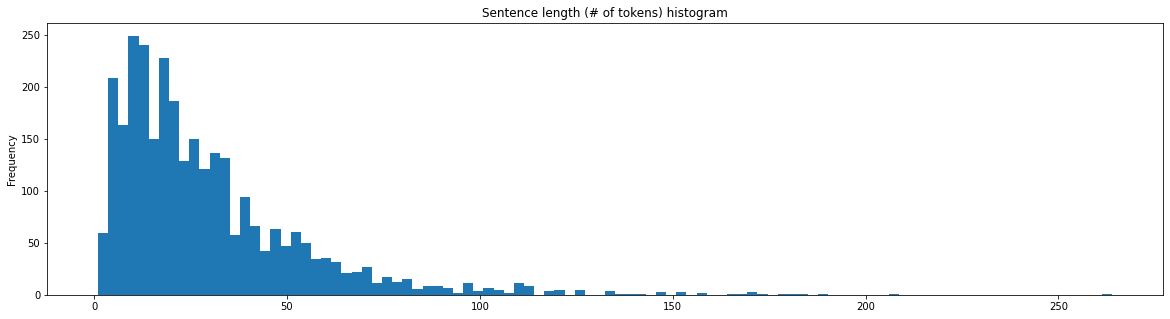

In [10]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(20,5)})

x = [len(sentence) for paragraph in tokenized_text for sentence in paragraph]
plt.hist(x, bins=100)
plt.gca().set(title='Sentence length (# of tokens) histogram', ylabel='Frequency');
# To learn more about matplotlib visit https://matplotlib.org/

## Getting the status of a webservice access key

In [11]:
def get_key_status():
    '''Returns a string with the detailed status of the webservice access key'''
    
    request_data = {
        'method': 'key_status',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'key': LXTOKENIZER_WS_API_KEY,
        },
    }
    request = requests.post(LXTOKENIZER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

In [12]:
get_key_status()

{'requests_remaining': 99999985,
 'chars_remaining': 998810285,
 'expiry': '2030-01-10T00:00+00:00'}